In [210]:
import torch
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd


temperature_2m (°C)

In [211]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [212]:

weather=pd.read_csv('data/hourly.csv',index_col='time',parse_dates=True)

weather


,temperature_2m,apparent_temperature,precipitation_probability,precipitation,rain
time,,,,,
2023-08-27 19:00:00,NaN,NaN,NaN,NaN,NaN
2023-08-27 20:00:00,NaN,NaN,NaN,NaN,NaN
2023-08-27 21:00:00,NaN,NaN,NaN,NaN,NaN
2023-08-27 22:00:00,NaN,NaN,NaN,NaN,NaN
2023-08-27 23:00:00,27.385000,32.860813,NaN,0.0,0.0
...,...,...,...,...,...
2024-01-30 14:00:00,17.185000,17.973215,0.0,0.0,0.0
2024-01-30 15:00:00,16.185000,16.901530,0.0,0.0,0.0
2024-01-30 16:00:00,15.485001,16.188198,0.0,0.0,0.0


In [213]:
def nullpecentage(weather):
    null_columns=weather.columns[weather.isnull().any()]
    null_pct=weather[null_columns].isnull().sum()*100/len(weather)
    weather=weather.ffill()
    return null_pct


In [214]:

nullpecentage(weather)

temperature_2m               0.106838
apparent_temperature         0.106838
precipitation_probability    5.582265
precipitation                0.106838
rain                         0.106838
dtype: float64

In [215]:

weather.dtypes

temperature_2m               float64
apparent_temperature         float64
precipitation_probability    float64
precipitation                float64
rain                         float64
dtype: object

In [216]:
weather.index=pd.to_datetime(weather.index)
weather.index.year.value_counts().sort_index()

time
2023    3029
2024     715
Name: count, dtype: int64

In [217]:
def convert(weather,target,column):
    weather[target]=weather[column].shift(-1)
    
convert(weather,"target_temp","temperature_2m")
convert(weather,"target_preci","precipitation_probability")
weather=weather.ffill()
print(nullpecentage(weather))



temperature_2m               0.106838
apparent_temperature         0.106838
precipitation_probability    5.582265
precipitation                0.106838
rain                         0.106838
target_temp                  0.080128
target_preci                 5.555556
dtype: float64


In [218]:
from sklearn.linear_model import Ridge
wmodel=Ridge(alpha=0.01)
pred=weather.columns[~weather.columns.isin(["target_temp"])]



In [219]:
weather.shape[0]

3744

In [220]:
def backtest(weather,model,pred,target,start=24,step=4,):
    all_pred=[] 
    for i in range(start,weather.shape[0],step):
        train=weather.iloc[:i,:]
        test=weather.iloc[i:i+step,:]
        model.fit(train[pred],train[target])
        predict=model.predict(test[pred])
        predict=pd.Series(predict,index=test.index) 
        combined=pd.concat([predict,test[target]],axis=1)
        combined.columns=["predict","actual"]
        combined["diff"]=(combined["predict"]-combined["actual"]).abs()
        all_pred.append(combined)
    return pd.concat(all_pred)

        
      

In [221]:
def pct_diff(old,new):
    return (new-old)/old
def rolling(weather,horizon,col):
    lablel=f"rolling_{horizon}_{col}"
    weather[lablel]=weather[col].rolling(horizon).mean()
    weather[f"{lablel}_pct"]=pct_diff(weather[lablel],weather[col])
    return weather

    
    

In [222]:
def compute_rolling(weather,column,):
    rolling_horizon=[3,6]
    for horizon in rolling_horizon:
        for col in [column]:
            weather=rolling(weather,horizon,col)
    weather=weather.iloc[6:,:]
    weather.fillna(0,inplace=True)
    return weather
    
    # prediction=backtest(weather,wmodel,pred,target)
    # print(prediction.sort_values("time",ascending=False).head(30))

    # print((prediction["diff"].round().value_counts().sort_index() / prediction.shape[0]).plot())

# weather=compute_rolling(weather,"target_temp","temperature_2m",pred)
# prediction=backtest(weather,wmodel,pred,"target_temp")



In [223]:
def call_pred(weather):    
    pred=weather.columns[~weather.columns.isin(["target_temp"])]
    prediction=backtest(weather,wmodel,pred,"target_temp")
    prediction.sort_values("diff",ascending=False)
    print(prediction.sort_values("time",ascending=False).head(60))
    (prediction["diff"].round().value_counts().sort_index() / prediction.shape[0]).plot()



C:\Users\ADIDAS\AppData\Local\Temp\ipykernel_5592\477098316.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather.fillna(0,inplace=True)


                       predict     actual      diff
time                                               
2024-01-30 18:00:00  14.149548  14.335000  0.185452
2024-01-30 17:00:00  14.559889  14.335000  0.224889
2024-01-30 16:00:00  15.057379  14.835000  0.222379
2024-01-30 15:00:00  15.344265  15.485001  0.140736
2024-01-30 14:00:00  16.018632  16.185000  0.166368
2024-01-30 13:00:00  17.615188  17.185000  0.430188
2024-01-30 12:00:00  19.306609  18.585000  0.721609
2024-01-30 11:00:00  20.136461  19.835000  0.301461
2024-01-30 10:00:00  20.567738  20.335000  0.232738
2024-01-30 09:00:00  20.305630  20.435000  0.129370
2024-01-30 08:00:00  20.173830  19.935000  0.238830
2024-01-30 07:00:00  19.837513  19.135000  0.702513
2024-01-30 06:00:00  17.986142  17.935000  0.051142
2024-01-30 05:00:00  15.192689  15.635000  0.442311
2024-01-30 04:00:00  11.799906  13.285001  1.485095
2024-01-30 03:00:00  11.561372  11.135000  0.426372
2024-01-30 02:00:00  11.173827  10.835000  0.338827
2024-01-30 0

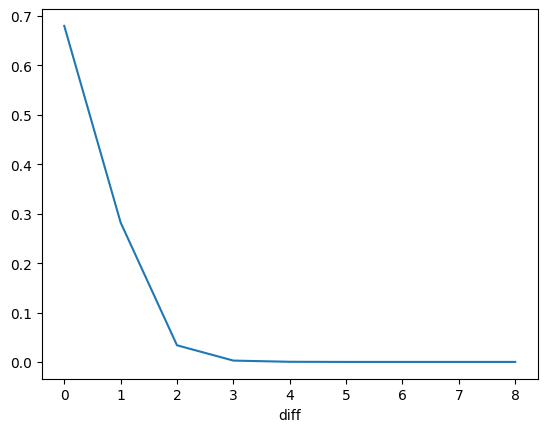

In [224]:


weather=compute_rolling(weather,"temperature_2m")
prediction=backtest(weather,wmodel,pred,"target_temp")
call_pred(weather)  


In [225]:
class weathermodel:
    
    
    def next_hour_prediction(self,weather,model,pred):
        train=weather.iloc[:-1,:]
        test=weather.iloc[-1:,:]
        
        
        model.fit(train[pred],train["target_temp"])
        predictt=model.predict(test[pred])
        return predictt

    def next_day_prediction(self,weather, model, pred):
        train = weather.iloc[:-1,:]
        test = weather.iloc[-24:,:]
        

        start_time = time.time()
        model.fit(train[pred], train["target_temp"])
        end_time = time.time()
        print(f"Training time: {end_time - start_time} seconds")

        start_time = time.time()
        predict = model.predict(test[pred])
        end_time = time.time()
        print(f"Prediction time: {end_time - start_time} seconds")
        predictions_df = pd.DataFrame({
            'Time Slot': test.index+pd.Timedelta(days=1),
            'Predicted Temp': predict
        })
        
        return predictions_df

    def display(self):
        print(self.next_day_prediction(weather,wmodel,pred))
    def display1(self):
        print("the next hour that is ", time.strftime("%H:%M:%S", time.localtime()), "the temperature will be ", self.next_hour_prediction(weather,wmodel,pred)[0], "°C")
        


In [226]:
#print(weatherm.next_day_prediction(weather,wmodel,pred))

weathermodel().next_day_prediction(weather,wmodel,pred)



Training time: 0.0015041828155517578 seconds
Prediction time: 0.001001119613647461 seconds


,Time Slot,Predicted Temp
0,2024-01-30 19:00:00,12.953478
1,2024-01-30 20:00:00,13.033887
2,2024-01-30 21:00:00,12.741606
3,2024-01-30 22:00:00,12.286263
4,2024-01-30 23:00:00,11.399641
5,2024-01-31 00:00:00,10.906772
6,2024-01-31 01:00:00,10.609479
7,2024-01-31 02:00:00,10.807163
8,2024-01-31 03:00:00,11.036558
9,2024-01-31 04:00:00,11.335605


In [227]:
weathermodel().display1()

the next hour that is  17:43:09 the temperature will be  14.459258589472029 °C


1.training
2.save
3.load
4.predict
